In [72]:
from Bio import SeqIO
from glob import glob
import os
import seaborn as sns
import matplotlib.pyplot as plt
import re
from graphviz import Source
import networkx as nx

def plot_style(figsize=(12, 6), labelsize=24, titlesize=28, ticklabelsize=20, **kwargs):
   basic_style = {
       'figure.figsize': figsize,
       'axes.labelsize': labelsize,
       'axes.titlesize': titlesize,
       'xtick.labelsize': ticklabelsize,
       'ytick.labelsize': ticklabelsize,
       'axes.spines.top': False,
       'axes.spines.right': False,
       'axes.spines.left': False,
       'axes.grid': False,
       'axes.grid.axis': 'y',
   }
   basic_style.update(kwargs)
   return plt.rc_context(rc=basic_style)

blue = sns.xkcd_rgb['ocean blue']


In [2]:
import numpy
numpy.__version__

'1.22.3'

In [3]:
from mito.genotyping import *

## Load reference

In [4]:
# Path to reference genome
reference_path = '../../data/reference/mito_GRCh38_gimlet.fasta'

with open(reference_path, 'r'):
    reference_seq = next(SeqIO.parse(reference_path, "fasta"))
reference = pd.Series(list(reference_seq.seq))

## Load read matrices

In [5]:
# Path to allele count files
INPUT_PATH = '../../data/P9855_and_bulk_ac_for_fig1_illustration'

In [6]:
cell_count = []

# Get all allele counts files in the input path
cell_count_filenames = list(glob(os.path.join(INPUT_PATH, '*.txt'))) #*.txt

for filename in sorted(cell_count_filenames):
    print('Reading {}'.format(filename))
    name = os.path.basename(filename).split('.')[0]
    

    # Load one allele count file
    counts = pd.read_csv(filename, sep='\t')
    counts.name = name
    cell_count.append(counts)
    
# Get sample order

sample_list = []

for filename in sorted(cell_count_filenames):
    name = os.path.basename(filename).split('-')[0]
    sample_list.append(name)

sample_list_df = pd.DataFrame(sample_list)
sample_list_df = sample_list_df.rename(columns={0: 'cell'})

Reading ../../data/P9855_and_bulk_ac_for_fig1_illustration/P3861_218.clean.dedup_ac.txt
Reading ../../data/P9855_and_bulk_ac_for_fig1_illustration/P9855_2089_S112_L004_ac.txt
Reading ../../data/P9855_and_bulk_ac_for_fig1_illustration/P9855_2090_S113_L004_ac.txt
Reading ../../data/P9855_and_bulk_ac_for_fig1_illustration/P9855_2104_S127_L006_ac.txt
Reading ../../data/P9855_and_bulk_ac_for_fig1_illustration/P9855_2110_S133_L007_ac.txt
Reading ../../data/P9855_and_bulk_ac_for_fig1_illustration/P9855_2111_S134_L007_ac.txt
Reading ../../data/P9855_and_bulk_ac_for_fig1_illustration/P9855_2112_S135_L007_ac.txt


In [7]:
e_rates = [0.001]

## Compute mutations probabilities

In [8]:
def cell_prob(e_rate):
    
    error_rate_when_no_mutation = error_rate_when_mutation = e_rate
    p_mutation = 1 / 1000.0

    cell_prob = []
    for count in cell_count:
        count = count.iloc[:reference.shape[0]]  # discard trailing positions
        p = nucleotide_mutation_prob(
            cell_counts=count,
            reference=reference,
            error_rate_when_no_mutation=error_rate_when_no_mutation,
            error_rate_when_mutation=error_rate_when_mutation,
            p_mutation=p_mutation,
        )

        cell_prob.append(p)
        
    # Compute P(mutation | read counts)
    cells_p_mutation = []
    for cell_prob in cell_prob:
        p = mutation_prob(cell_prob, reference)
        cells_p_mutation.append(p)
        
        
    # Make mutation matrix
    mutation_matrix = cells_p_mutation[0][['#CHR', 'POS']].copy()
    mutation_matrix_data = pd.DataFrame(np.dstack([c['Prob_mutation'].values for c in cells_p_mutation]).squeeze())
    mutation_matrix = pd.concat([mutation_matrix, mutation_matrix_data], axis=1)
    return mutation_matrix      

## Filter pmat

In [98]:
def flt_pmat(e_rate):
    mutation_matrix = cell_prob(e_rate)

    # Remove germline mutations
    mutation_matrix = mutation_matrix.loc[mutation_matrix[0] < 0.9]
    
    # Probabilities for location with mutation at any of the cells
    mutation_threshold = 0.9
    data = mutation_matrix.set_index('POS').drop('#CHR', axis=1)
    mutation_any_cell = data[(data > mutation_threshold).any(axis=1)]
    
    # select rows that have a value greater than mutation_threshold in more than x cells
    mutation_threshold = 0.9
    mask = (data.values > mutation_threshold).sum(axis=1) > 1 #create an array with boolean values and sum these along the axis and select rows with more than 1 True
    two_cells_have_mut = data[mask]

    # Fix matrix
    half = len(two_cells_have_mut.columns) / 2

    # Remove rows where 50% of cols are nan and save in new df
    nan_rows = two_cells_have_mut.drop(two_cells_have_mut[(two_cells_have_mut.isna()).sum(axis=1)> half].index)

    # Replace NaN with row mean
    imputed = nan_rows.transpose().fillna(nan_rows.mean(axis=1)).transpose()
    
    # To skip removal of sites with overall high probability for mut
    high_prob_rows = imputed.copy()
    
    # Replace 1.0
    high_prob_rows = high_prob_rows.replace(1.0, 0.99999)
    
    #np.set_printoptions(suppress=True)
    #e_rate_name = str(e_rate)
    #matrix_path = '../../data/illustration_fig1_matrix_output/' + e_rate_name + '.csv'
    #high_prob_rows.to_csv(matrix_path, index=False, sep=' ', header= False)
    return high_prob_rows
    
    #print positions
    #matrix_path = '../../data/P9855_matrix_output_w_pos/' + e_rate_name + '.csv'
    #high_prob_rows.to_csv(matrix_path, sep='\t', header=False)
    


In [99]:
for e_rate in e_rates:
    high_prob_rows = flt_pmat(e_rate)

/Users/johard/Documents/mcmt/MCMT/Notebooks/mito/genotyping.py:251: FutureWarning: The 'lookup' method is deprecated and will be removed in a future version. You can use DataFrame.melt and DataFrame.loc as a substitute.
  prob_mutation['Prob_mutation'] = 1 - p.lookup(p.index, reference.values)
/Users/johard/Documents/mcmt/MCMT/Notebooks/mito/genotyping.py:251: FutureWarning: The 'lookup' method is deprecated and will be removed in a future version. You can use DataFrame.melt and DataFrame.loc as a substitute.
  prob_mutation['Prob_mutation'] = 1 - p.lookup(p.index, reference.values)
/Users/johard/Documents/mcmt/MCMT/Notebooks/mito/genotyping.py:251: FutureWarning: The 'lookup' method is deprecated and will be removed in a future version. You can use DataFrame.melt and DataFrame.loc as a substitute.
  prob_mutation['Prob_mutation'] = 1 - p.lookup(p.index, reference.values)
/Users/johard/Documents/mcmt/MCMT/Notebooks/mito/genotyping.py:251: FutureWarning: The 'lookup' method is deprecate

In [215]:
# Remove some mutations
rows_to_remove = [3109, 36, 1782, 10799, 5798, 7151, 15523, 1126]
pmat = high_prob_rows.drop(rows_to_remove)

## Probability distribution

In [217]:
# change order of rows so that shared mutations come first, then clonal mutations
row_order = [6533, 14320, 7632, 9478, 12946, 2361, 2844, 5130]


pmat = pmat.reindex(row_order)


In [195]:
# Save the pmat
e_rate_name = str(e_rate)
matrix_path = '../../data/illustration_fig1_matrix_output/' + e_rate_name + '.csv'
pmat.to_csv(matrix_path, index=False, sep=' ', header= False)


In [220]:
# change order of cols so that clonal samples are together
column_labels = pd.Series(['s' + str(i) for i in pmat.columns])
pmat.columns = column_labels
cols = ['s0', 's1', 's2', 's3', 's6', 's4', 's5']
pmat = pmat[cols]

In [226]:
pmat.reset_index(drop=True, inplace=True)
pmat.index += 1
pmat

,s0,s1,s2,s3,s6,s4,s5
1,5.159130e-07,9.999900e-01,9.999900e-01,9.999900e-01,9.999900e-01,9.999900e-01,9.999900e-01
2,1.886357e-07,9.999900e-01,9.999900e-01,9.999900e-01,9.999900e-01,9.999900e-01,3.088887e-01
3,2.349223e-07,9.999299e-01,6.427157e-01,9.999900e-01,8.981229e-02,9.527401e-01,1.146645e-06
4,5.930433e-07,9.999914e-01,8.600483e-01,8.738560e-04,9.998191e-01,9.676291e-01,6.570731e-05
5,1.455155e-07,9.999900e-01,1.000000e+00,8.901764e-09,1.625345e-09,3.107531e-08,3.854333e-08
6,1.578699e-07,2.682286e-08,6.084795e-09,9.999900e-01,9.999900e-01,6.617613e-09,1.286364e-08
7,1.626445e-07,1.463487e-07,4.131325e-07,2.923153e-08,3.642401e-06,9.999900e-01,9.999900e-01
8,2.434848e-07,9.559440e-08,3.509680e-08,3.526981e-08,1.753388e-07,9.999900e-01,9.999900e-01


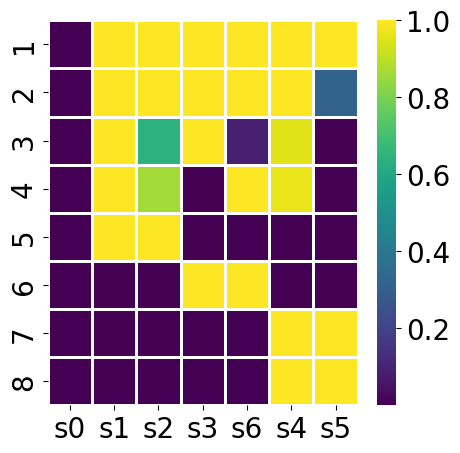

In [233]:
plot_pmat = pmat.copy()#.fillna(0)
#plot_pmat.columns = column_labels

with plot_style(figsize=(5, 5)):
    sns.heatmap(plot_pmat, cmap='viridis', linecolor='white', linewidths=1)
    plt.xlabel('')

plt.savefig(f'../../data/illustration_fig1_figures/0.001_pmat_heatmap.svg')


## Now run mt-SCITE

In [198]:
# prepare pmat data

pmat_names = []
shapes = []

pmat_input_path = f'../../data/illustration_fig1_matrix_output/'
#print(pmat_input_path)
pmats = list(glob(os.path.join(pmat_input_path, '*.csv')))
tree_name = []

for filename in sorted(pmats):
    name = os.path.basename(filename).split('-')[0].rsplit('.', 1)[0]
    #print(name)
    pmat_names.append(name)
    df = pd.read_csv(filename, sep=' ', header=None)
    shapes.append(len(df))

# make df with pmat info
pmat_data = pd.DataFrame(
    {'pmat_names': pmat_names,
     'len': shapes,
    })

pmat_data

,pmat_names,len
0,0.001,8


In [199]:
# Check n samples
a_pmat = pd.read_csv('../../data/illustration_fig1_matrix_output/0.001.csv', sep=' ', header=None)
n_cells = a_pmat.shape[1]
n_cells

7

In [200]:
# Run mt-SCITE

SCITE_PATH = '../../../mt-SCITE'
PMAT_PATH = f'../../data/illustration_fig1_matrix_output/'
OUTPUT = f'../../../mt-SCITE/mt-SCITE_output/llustration_fig1/'

for rep in range(1,2): #11
    
    for pmat in pmat_names:        
        run_id = pmat + '_' + str(rep)
        print('Running tree inference for error rate ' + pmat + ' repetition ' + str(rep))

        # Get number of mutations
        n = pmat_data.loc[pmat_data['pmat_names'] == pmat, 'len'].iloc[0].astype(str)

        try:
            os.makedirs(OUTPUT + '/stdout/') 
        except FileExistsError :
            pass
        except :
            raise

        ! $SCITE_PATH/mt-SCITE/scite -i $PMAT_PATH/$pmat\.csv -n $n -m $n_cells -r 1 -l 200000 -fd 0.0001 -ad 0.0001 -cc 0.0 -s -a -o $OUTPUT/$run_id 1> $OUTPUT/stdout/$run_id\.stdout.txt
        
 

Running tree inference for error rate 0.001 repetition 1


## Plot a tree

In [201]:
def new_count_row(all_clone_names, clone_name=None):
    """ Create a DataFrame row with one entry per clone name. 
    
    If `clone_name` is not None, initialize that entry to 1.
    """
    row = pd.Series(data=0, index=all_clone_names)
    if clone_name is not None:
        row[clone_name] = 1
    return row

def dfs_clones_count(g, clones, all_clone_names, source_node):
    clones_count = pd.DataFrame({sample_name: new_count_row(all_clones, clone_name) for sample_name, clone_name in clones.items()})
    for pre_node, post_node, edge_label in nx.dfs_labeled_edges(g, source_node):
        if edge_label is not 'reverse' or pre_node == post_node: 
            continue
        pre_node_counter = clones_count.get(pre_node, new_count_row(all_clones))
        if post_node not in clones_count.columns:
            print('!! possible mutation in a leaf: not found', post_node)
            continue
        clones_count[pre_node] = pre_node_counter + clones_count[post_node]

    return clones_count

def purity(clones_count):
    return clones_count.div(clones_count.sum(axis=0), axis=1)

def get_root_node(t):
    root_nodes = [n for n,d in t.in_degree() if d==0]
    print(root_nodes)
    #assert len(root_nodes) == 1
    root_node = root_nodes[0]
    return root_node

<>:14: SyntaxWarning: "is not" with a literal. Did you mean "!="?
<>:14: SyntaxWarning: "is not" with a literal. Did you mean "!="?
/var/folders/vw/hdz80fyj66q3q6n5fkgfmvf80000gs/T/ipykernel_10190/3756212178.py:14: SyntaxWarning: "is not" with a literal. Did you mean "!="?
  if edge_label is not 'reverse' or pre_node == post_node:


In [202]:
# Load clones map
data = [['bulk', 's0', 'P3861_218.clean.dedup_ac.txt', 'ss0'],
        ['A', 's1', 'P9855_2089_S112_L004_ac.txt', 'ss1'],
        ['A', 's2', 'P9855_2090_S113_L004_ac.txt', 'ss2'],
        ['B', 's3', 'P9855_2104_S127_L006_ac.txt', 'ss3'],
        ['C', 's4', 'P9855_2110_S133_L007_ac.txt', 'ss4'],
        ['C', 's5', 'P9855_2111_S134_L007_ac.txt', 'ss5'],
        ['B', 's6', 'P9855_2112_S135_L007_ac.txt', 'ss6']]

clones_map_raw = pd.DataFrame(data, columns=['clone', 'tree_id', 'cell_id', 'node_name'])

clones_map_raw

,clone,tree_id,cell_id,node_name
0,bulk,s0,P3861_218.clean.dedup_ac.txt,ss0
1,A,s1,P9855_2089_S112_L004_ac.txt,ss1
2,A,s2,P9855_2090_S113_L004_ac.txt,ss2
3,B,s3,P9855_2104_S127_L006_ac.txt,ss3
4,C,s4,P9855_2110_S133_L007_ac.txt,ss4
5,C,s5,P9855_2111_S134_L007_ac.txt,ss5
6,B,s6,P9855_2112_S135_L007_ac.txt,ss6


In [203]:
clones_map = dict(clones_map_raw[['tree_id', 'clone']].values)
all_clones = list(clones_map_raw.clone.unique())

In [204]:
all_clones

['bulk', 'A', 'B', 'C']

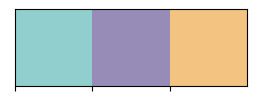

In [205]:
flatui = ['#91CFCF', '#978CB7', '#F2C381'] 
sns.palplot(sns.color_palette(flatui))

In [206]:
colors = sns.color_palette(sns.color_palette(flatui))

clone_color = {
    'bulk': (0, 0, 0),
    'A': np.array(colors[0]) * 255,
    'B': np.array(colors[1]) * 255,
    'C': np.array(colors[2]) * 255,
}

In [207]:
clone_color

{'bulk': (0, 0, 0),
 'A': array([145., 207., 207.]),
 'B': array([151., 140., 183.]),
 'C': array([242., 195., 129.])}

In [208]:
# Load target tree
tree_filename = f'../../../mt-SCITE/mt-SCITE_output/llustration_fig1/0.001_1_map0.gv'
tree = nx.drawing.nx_pydot.read_dot(tree_filename)

In [209]:
# tree contains some empty trailing node. Check that it is removed.
print(len(tree.nodes()))
tree.remove_node('\\n')
print(len(tree.nodes()))

17
16


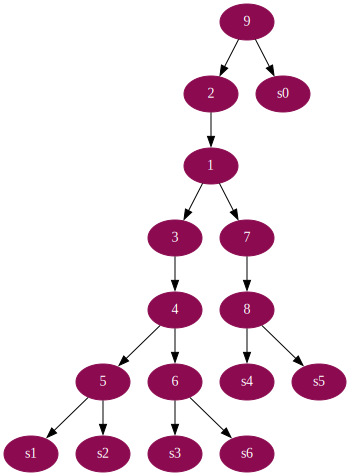

In [210]:
from networkx.drawing.nx_agraph import graphviz_layout, to_agraph
g = to_agraph(tree)
g.layout('dot')
#g.draw(f'figs/trees/{error_rate}_map{tree_number}.pdf')
Source(g)

In [211]:
def rgb_to_hex(colortuple):
    return '#' + ''.join(f'{int(i):02X}' for i in colortuple)

def mix_clones_colors(node_name, purities):
    node_purities = purities[node_name]
    color = 0
    for clone, frac in node_purities.iteritems():
        color += frac * np.array(clone_color[clone])
    return color.astype(int)


clones_count = dfs_clones_count(tree, clones_map, all_clones, source_node=get_root_node(tree))
clones_purity = purity(clones_count)

for n in tree.nodes:
    node_dict = tree.nodes[n]
    if n.startswith('s'):
        # This is the style for sample nodes
        clone = clones_map[n]
        node_dict['color'] = rgb_to_hex(clone_color[clone])
        node_dict['shape'] = 'circle' #square
    else:
        if n in clones_purity:
            # This is the style for mutation nodes
            # Color is a mix of purities
            node_dict['color'] = rgb_to_hex(mix_clones_colors(n, clones_purity))
        else:
            # Dangling mutation node
            node_dict['color'] = 'black'

['9']


In [212]:
# Global graph style
tree.graph['node']['shape'] = 'square' #circle
tree.graph['node']['fontcolor'] = 'white'
tree.graph['edges'] = {'arrowsize': '4'}
tree.graph

{'name': 'G',
 'node': {'color': 'deeppink4',
  'style': 'filled',
  'fontcolor': 'white',
  'shape': 'square'},
 'edges': {'arrowsize': '4'}}

In [213]:
from networkx.drawing.nx_agraph import graphviz_layout, to_agraph
g = to_agraph(tree)

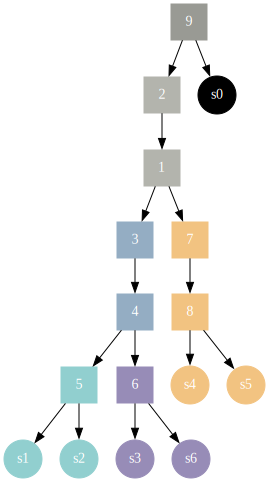

In [214]:
from networkx.drawing.nx_agraph import graphviz_layout, to_agraph
g = to_agraph(tree)
g.layout('dot')
g.draw(f'../../data/illustration_fig1_figures/0.001_1_map0.svg')
Source(g)